# LH010 🔶 PySpark Drills 4: Data cleaning

>  **Note**: this tutorial is provided for educational purposes, for members of the [Fabric Dojo community](https://skool.com). All content contained within is protected by Copyright © law. Do not copy or re-distribute. 

Welcome to the 4th of five drill-style tutorials. The goal of this mini-series is to expose you to a wide variety of commonly used PySpark functions. 

In this 4th tutorial in the mini-series, we will look at data cleaning, and specifically handling of duplicates & missing values. 

You'll be given an empty code cell to write the code for each drill. Try to complete each drill without the use of the walkthrough video, but it's there if you need it! 

#### Prerequisites
1. You should already have a Lakehouse in your Fabric Workspace (from the previous exercise) - LH007_PropertyLH 
2. Load this notebook into your Fabric Workspace. Connect this notebook to the LH007_PropertyLH Lakehouse. 
3. Download the `property-sales-messy.csv` file from the Skool tutorial page, and upload it into your Lakehouse Files area. 
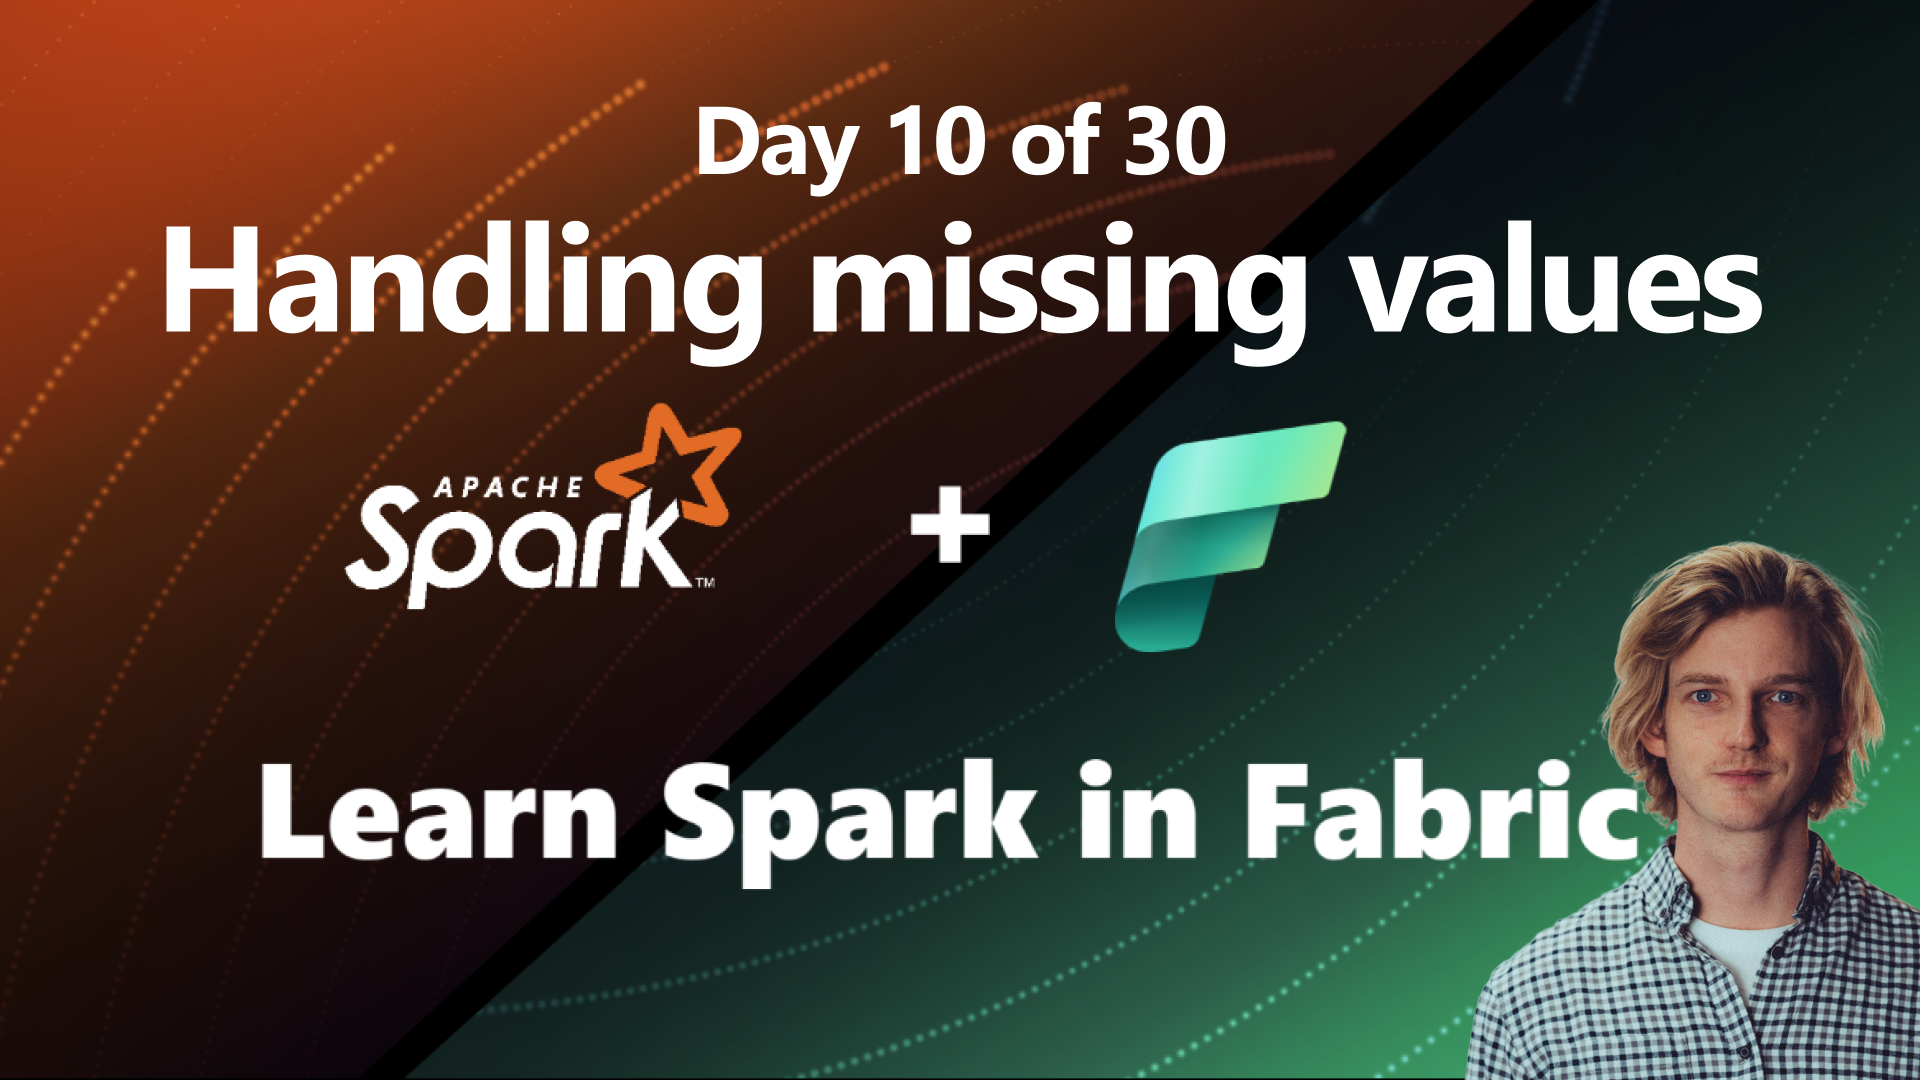

#### Setup: Loading a dataset 
Once you have the `property-sales-messy.csv` dataset in your Lakehouse Files area, run the following script to load that data into a DataFrame. 

This dataset still represents property sales in US cities, but now there is more data, and the data is messy. A number of data quality issues have been introduced to the dataset. It's your goal to identity and then fix/ remove these data quality issues.

To narrow your search a little, you can expect to find the following issues with the dataset: 
- Duplicate rows of data
- messy input in the SalePriceUSD column - you can see this because when you load the data with inferSchema=True, you will notice that if infers it as a string. It also contains some missing values in that column. 

In this notebook, we will detect and then fix as best possible these data quality issues. 





In [ ]:
df = (
    spark.read.format("csv")
        .option("header","true")
        .option("inferSchema", True)
        .load("Files/property-sales-messy.csv")
)

display(df)

#### Drill 4.1 Duplicate rows
This dataset represents a Fact table. It is expected that each row has a unique SaleID. 

With Spark we can use the df.dropDuplicates() function to detect and remove duplicate data. 

Using [df.dropDuplicates()](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.dropDuplicates.html), remove the duplicates from the dataset and save the result to a new variable called `df_deduped`. 

Then calculate the difference in row count between your original df and df_deduped - how many rows have been removed? (It should be 5)

In [ ]:
df_deduped =  df.dropDuplicates() 

df.count() - df_deduped.count() 

The df.dropDuplicates() method can be modified to check specific columns for duplicate values, or the whole row. Bear this in mind as you develop your data cleaning strategy. It all depends on what makes sense for your dataset. 

For example, if there were two rows in your dataset with the same SaleID, but a different SalePriceUSD, just the default df.dropDuplicates() would not remove this row, and if you perform a df.dropDuplicates(['SaleID']) on just the SaleID column, how do you know that the correct SalePriceUSD has been removed? If these case, it's worth quarantining the data for individual inspection (rather than an automated removal, which might remove valid data!).




#### Drill 4.2: Discovering data quality issues in a column  

If our goal is to build automated data cleansing routines, we need to approach it step-by-step. 

1. Firstly, we need to explore the data to look for data quality issues that are occurring in the dataset. 
2. Then, we need to think about how we can identity each data quality issue individually through code. 
3. Then, for each case, we need to build a strategy for treatment: this could range from complete removal of the row, cleaning, missing value imputation etc. It very much depends on the dataset, the column, and the type of data quality issue. 
4. Finally, you need to combine the detection of that particular data quality issue, with the treatment in a reusable function. 

Let's go through this one-by-one with an example. We are going to be focusing on the SalePriceUSD column in our dataset. 

Your first task to **explore the data in this SalePirceUSD column**. You could do this by looking at the original CSV in Excel, but try to use code to explore the data, as when your dataset is in the millions of rows, it becomes difficult to visually assess data quality issues, and it's good to practice. 



In [ ]:
# looking for values outside an expected range
df.filter((df.SalePriceUSD < 100000) | (df.SalePriceUSD > 30000000)).show()

# looking for non-numeric values 
df.filter(df.SalePriceUSD.rlike("[^0-9]")).show()

# exploring the number of NULL values in the column 
df.filter(df.SalePriceUSD.isNull()).show()

# exploring the number of NULL values in the column 
# df.filter(df.SalePriceUSD.cast("integer").isNull()).count()

Let's focus on three data quality issues that our (my) investigation found. 
1. Non-numeric characters in the SalePriceUSD column (you can use regular expressions to find these)
2. Values that fall outside a reasonable range. 
3. NULL values in the SalePriceUSD column

#### Drill 4.3: Removal of non-numeric values 

The first thing we'll do is remove non-numeric values from the SalePriceUSD column. 

To identify these values/ rows in Drill 4.2, I used the [rlike()]() regular expression method. 

Now, we don't want to just identify these rows, we want to remove non-numeric characters from our SalePriceUSD column. Because values like $100,000 - will not convert to an integer value, which is ultimately what we want to do. 

Luckily, Spark has a function for this. So, using the function [regexp_replace](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.regexp_replace.html), and the regular expression "[^0-9]", **remove non-numeric values from the SalePriceUSD column. Save the resulting dataframe as a new variable, called `clean_df`:** 



In [ ]:
# import regex_replace() 
from pyspark.sql.functions import regexp_replace

# the previous script for identifying rows with non-numeric chars in SalePriceUSD 
# df.filter(df.SalePriceUSD.rlike("[^0-9]")).show()

# remove non-numeric characters from the SalePriceUSD column, and assign to clean_df varaible
clean_df = df.withColumn("SalePriceUSD", regexp_replace("SalePriceUSD", "[^0-9]", ""))
display(clean_df)

#### Drill 4.4: Casting a column to a new data type 

Currently, our SalePriceUSD column is still a string value, but, now we have removed the non-numeric values from it, we should be able to CAST the column as an integer. _Note: you could have done this before the removal of non-numeric values, but it would've removed values like "$100,000" by removing the non-numeric values first in our process, we preserved these values._

Using df.withColumn() and cast(), **convert the SalePriceUSD column to an integer value, and reassign the whole dataframe to the clean_df variable:**  

_Note: after conversion, use df.dtypes to check the datatypes of the columns in your dataframe._


In [ ]:
# casting the SalePriceUSD column to an integer value
clean_df = clean_df.withColumn("SalePriceUSD", clean_df.SalePriceUSD.cast("int"))
clean_df.dtypes

#### Drill 4.5 Handling NULL values 

As well as the NULLs that existed in the original dataset, Spark will also add NULLS for any values it can't CAST correctly from one data type to another (for example, if you try to cast non-numeric values to an integer, it will return a NULL). 

Therefore, as a final step in our cleaning process, we will look at handling NULL values. 

There are many ways to deal with NULL values in a column, the strategy you choose depends on the business context, and 'what makes sense' for that particular dataset and column. 

The method we will explore here is to drop rows with missing values from our dataframe. This can be a valid strategy where the column is important, and without a value in there it makes the entire record useless. Again, this will depend on the context. 

Using [df.dropna()](https://spark.apache.org/docs/3.4.2/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.dropna.html) **drop the rows in the dataframe which are NULL in the SalePriceUSD column:** 

_Take note of how the dropna() method works, and which parameters we can pass in, and what the do._


In [ ]:
# drop rows from the df, where SalePriceUSD is null. 
clean_df = clean_df.dropna(subset='SalePriceUSD')

#check the row removal 
df.count() - clean_df.count() 

#### Drill 4.6 Removing records outside a given range 
Finally, we'll handle our 'given range' data quality issue. 

During the investigation stage we found that some rows contained a SalePriceUSD that does not fall within an expected range. 

Now, we want to remove these values from our dataframe. So, **write a script that removes rows from your clean_df that fall outside the expected range of 100000 and 3000000:**

In [ ]:
# print the rowcount before 
print(clean_df.count())

# removing outlier values from the dataframe
clean_df = clean_df.filter((clean_df.SalePriceUSD > 100000) & (clean_df.SalePriceUSD < 30000000))

# print the rowcount after 
print(clean_df.count())


#### Extension: Mean Imputation
Another common method for handling missing values in key columns is Imputation. This is used a lot in data science and machine learning. It involves replacing missing values with an imputed value. This is normally the mean value for that column (or for a given class, for example the average sale price in New York). This method is explored in [this video](https://youtu.be/H83lW_RkeRU). 

---

#### END